In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
sys.path.append('../src/')

from simulator import Simulator

from savgol.utils import savgol_filter
from savgol.utils import asymmetric_least_squares
from savgol.utils import durbin_watson_criterion
from savgol.utils import find_peaks

In [2]:
simulator = Simulator(
    resolution=16384,
    num_peaks_range=(1, 100),
    snr_range=(10.0, 30.0),
    amplitude_range=(25, 250),
    loc_range=(0.05, 0.95),
    scale_range=(0.001, 0.003),
    asymmetry_range=(-0.1, 0.1),
    noise_type='white',
)

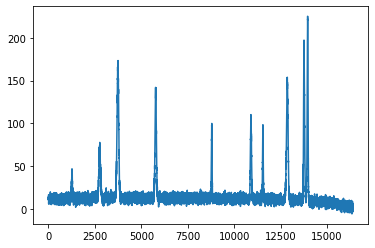

In [3]:
data = simulator._generate(10)

x = data['chromatogram']
plt.plot(x)

In [4]:
def search_savgol_params(x, params):
    best_val = float('inf')
    for order in params['polyorder']:
        for window in params['window_length']:
            
            z = savgol_filter(x, window, order)
            val = durbin_watson_criterion(x, z)
            if abs(val - 2.) < abs(best_val - 2.):
                best_val = val
                best_param = {'window_length': window, 'polyorder': order}
                
    return best_param


param = search_savgol_params(x, {'window_length': range(5, 301, 2), 'polyorder': [2]})

# NOTICE: current durbin-watson criterion does not work well for detecting peaks. 
#         the best params are smoothening to little!

print(param)

{'window_length': 15, 'polyorder': 2}


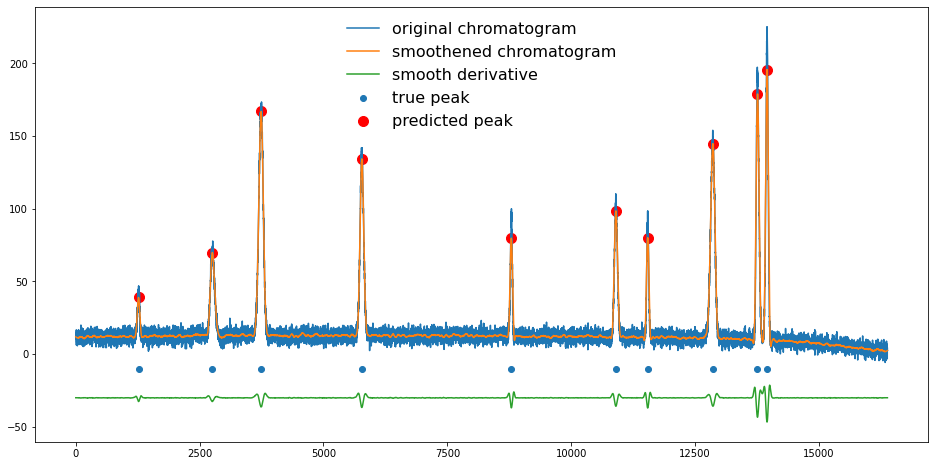

In [6]:
plt.figure(figsize=(16, 8))

# Lets use big window size for better peak detection
x_smooth, x_deriv = savgol_filter(x, window_length=101, deriv=2)

# Find peaks by finding the local minima in the second derivative
loc = find_peaks(x_deriv, height=0.01, distance=30)

# Plot out stuff
plt.plot(x, label='original chromatogram')
plt.plot(x_smooth, label='smoothened chromatogram')
plt.scatter(data['loc']*len(x), [-10.]*len(data['loc']), label='true peak')
plt.scatter(loc, x_smooth[loc], color='red', s=100, label='predicted peak')

# plot out derivative. multiplied by 100 to increase the magnitude, 
# and subtract it to move it down. only for visualization purposes
plt.plot(x_deriv * 100 - 30, label='smooth derivative')
plt.legend(fontsize=16, frameon=False);
